# 2 qubit GST for XYICZ gate: Testing random sequence constructions

In [116]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [121]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
from random import sample
#from pygsti.modelpacks import smq2Q_XYICNOT as std

%run ../src/mGST/reporting.py

### Setting the parameters

In [25]:
pdim = 4   # physical dimension
r = pdim**2   # rank of the gate superoperators 

max_l = 10  # maximum number of gates in each measurement sequence
n_povm = 4   # number of POVM-elements
d = 6

In [26]:
from true_values import E_true, X_true, rho_true
X_t = X_true[:d].copy()
E_t = E_true.copy()
rho_t = rho_true.copy()
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std')
noisy_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std').depolarize(0.001,spam_noise=0.05).randomize_with_unitary(0.01)
X_noisy, E_noisy, rho_noisy = compatibility.pygsti_model_to_arrays(noisy_mdl, basis = 'std')

### Generating data

In [5]:
def random_len_seq_2(d,min_l,max_l,N):
    seq_lengths = np.sort(np.random.randint(min_l,max_l+1,N))
    J = []
    for l in seq_lengths:
        j_curr = np.random.randint(0,d,l)
        J.append(list(np.pad(j_curr,(0,max_l-l),'constant',constant_values=-1)))
    return np.array(J)

def random_len_seq_3(d,min_l,max_l,N): #Draws without replacement but inneficiently (not working for sequences length > 24)
    seq_counts = []
    J = [-np.ones(max_l)]
    N_remaining = N - 1
    for l in range(min_l,max_l+1):
        seq_counts.append(int(np.min([np.floor(N_remaining/(max_l+1-l)), d**l])))
        ind_curr = np.array(sample(range(d**l), seq_counts[-1]))
        J_curr = np.array([np.pad(low_level_jit.local_basis(ind,d,l),(0,max_l-l),'constant', constant_values = -1) for ind in ind_curr])
        J = np.concatenate((J,J_curr), axis = 0)
        N_remaining = N - 1 - np.sum(seq_counts)
    if N_remaining > 0:
        print('Number of possible sequences without replacement for the given sequence\
        length range is lower than the desired total number of sequences')
    return J.astype(int)

In [6]:
J = random_len_seq_3(d,1,8,500)

In [7]:
print(J.shape)

(500, 8)


In [8]:
l_min = 1
l_cut = 8
l_max = 24
N = 500
N_long = 300
meas_samples = 1e5
J = random_len_seq_3(d,l_min,l_cut,N)
J2 = random_len_seq_3(d,l_cut,l_max,N_long)

y = np.real(np.array([[E_noisy[i].conj()@low_level_jit.contract(X_noisy,j)@rho_noisy for j in J] for i in range(n_povm)]))
y = additional_fns.sampled_measurements(y,meas_samples).copy()

y2 = np.real(np.array([[E_noisy[i].conj()@low_level_jit.contract(X_noisy,j)@rho_noisy for j in J2] for i in range(n_povm)]))
y2 = additional_fns.sampled_measurements(y2,meas_samples).copy()

In [9]:
max_l_drawn = np.max(np.sum(J2>=0,axis = 1))
print(max_l_drawn)
J_all = []
for i in range(N):
    J_all.append(list(np.pad(J[i],(0,max_l_drawn-len(J[i])),'constant',constant_values=-1)))
for i in range(N_long):
    J_all.append(list(np.pad(J2[i],(0,max_l_drawn-len(J2[i])),'constant',constant_values=-1)))
J_all = np.array(J_all)

J_reduced = []
for i in range(N):
    J_reduced.append(list(J[i,:][J[i,:]>=0]))
for i in range(N_long):
    J_reduced.append(list(J2[i,:][J2[i,:]>=0]))
y_all = np.concatenate((y,y2), axis = 1)

24


In [10]:
print(y_all.shape)

(4, 800)


In [11]:
import csv

# with open('sequences.csv', 'w', newline='') as myfile:
#    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#    wr.writerows(J_reduced)

### Loading data

In [44]:
# Hardware probabilities
filename = 'data/20230525-1313_cgst_2q.json'

with open(filename) as f:
    data = json.load(f)
    
#N = data['nsequences']
N = len(data['measurements']) 
print('Number of sequences ', N)


def get_hardware_probability(probs, key):
    # returns 0 for missing keys
    if key in probs:
        return probs[key]
    else:
        return 0


max_l = 0
for entry in data['measurements']:
#    print(entry['circuit'])
#    print(entry['hardware_probabilities'])
    if len(entry['circuit']) > max_l:
        max_l = len(entry['circuit'])
print('Max length', max_l)

# Zero pad and turn around circuits
J_all = np.array([list(np.pad(np.int64(data['measurements'][i]['circuit']),(0,max_l-len(data['measurements'][i]['circuit'])),'constant',constant_values=-1)) for i in range(N)])[:,::-1]



y_all = np.array([[
    get_hardware_probability(data['measurements'][i]['hardware_probabilities'],basis_str) for i in range(N)] for basis_str in ['00','01','10','11']])

y_all_ideal = np.array([[
    get_hardware_probability(data['measurements'][i]['simulation_probabilities'],basis_str) for i in range(N)] for basis_str in ['00','01','10','11']])


meas_samples = data['nshots']

# adjust threshold_multiplier if convergence is not reached


J = J_all[:500]
y = y_all[:,:500]


Number of sequences  799
Max length 24


In [40]:
# Check types
print(y_all.shape)
print(type(J_all))
print(type(J_all[0]))
print(type(J_all[0][0]))
print(type(y_all))
print(type(y_all[0]))
print(type(y_all[0][0]))

(4, 799)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


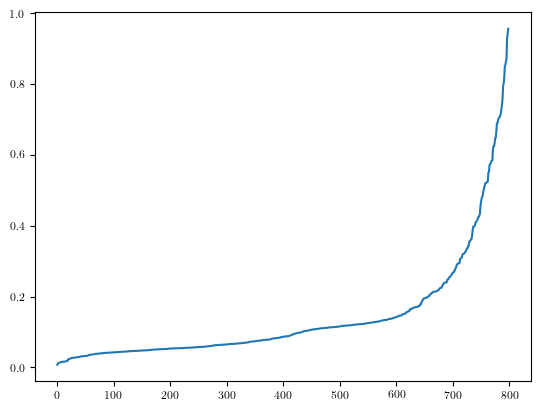

(1, 24)
of which do not contain 0
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]
[0.28660826032540676, 0.24603174603174602, 0.2540983606557377, 0.18716577540106952, 0.16901408450704225, 0.1509433962264151, 0.16279069767441862, 0.14285714285714285, 0.15, 0.18, 0.20454545454545456, 0.2222222222222222, 0.17857142857142858, 0.13636363636363635, 0.16666666666666666, 0.2727272727272727, 0.2222222222222222, 0.2857142857142857, 0.6666666666666666, 1.0]


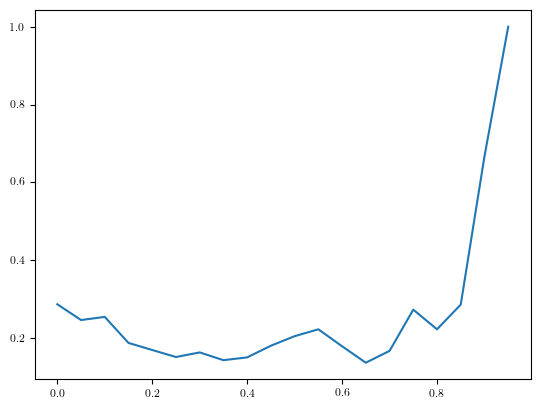

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3  5  5  3]]
[[0.9505]
 [0.0438]
 [0.0047]
 [0.001 ]]
[[0.]
 [1.]
 [0.]
 [0.]]


In [97]:
# Calculate TV distance to ideal probabilities
deviations = np.sum(np.abs(y_all - y_all_ideal), axis=0)/2
plt.plot(np.sort(deviations))
plt.show()



thress = np.arange(0,1,.05)

print(J_all[deviations > thres].shape)

print('of which do not contain 0')
ratios = [np.sum(np.logical_not(np.any(np.isin(J_all[deviations > thres], [0]), axis=1))) / J_all[deviations > thres].shape[0]
for thres in thress]

print(thress)
print(ratios)

plt.plot(thress, ratios)
plt.show()

print(J_all[deviations > .95])
print(y_all[:,deviations > .95])
print(y_all_ideal[:,deviations > .95])




### GST

Starting optimization...
  0%|                                                                             | 0/180 [00:00<?, ?it/s]

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


100%|███████████████████████████████████████████████████████████████████| 180/180 [04:42<00:00,  1.57s/it]


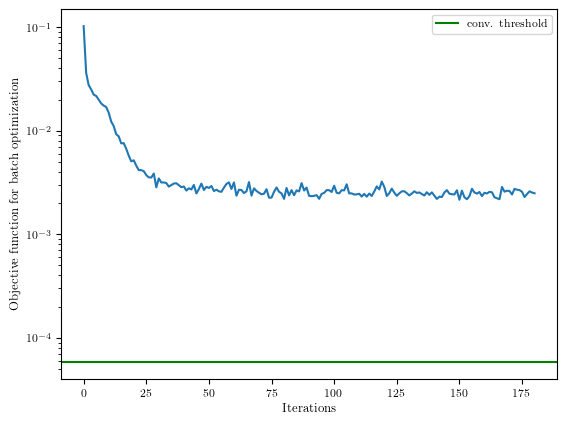

Run  0 failed, trying new initialization...
100%|███████████████████████████████████████████████████████████████████| 180/180 [04:40<00:00,  1.56s/it]


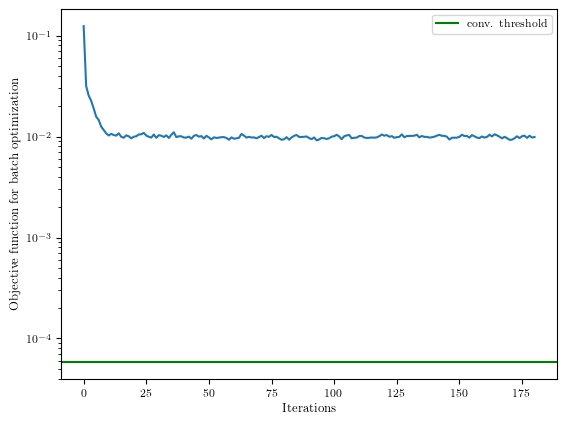

Run  1 failed, trying new initialization...
100%|███████████████████████████████████████████████████████████████████| 180/180 [04:47<00:00,  1.59s/it]


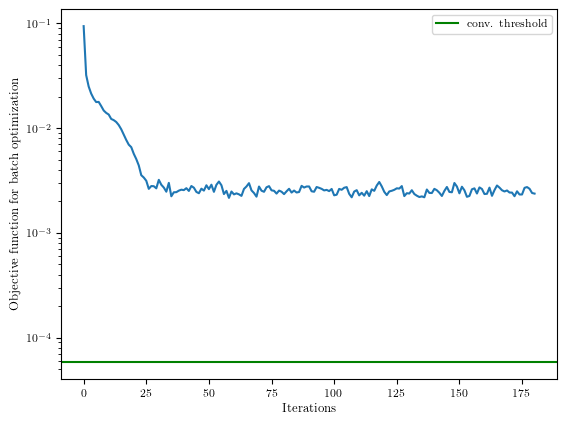

Run  2 failed, trying new initialization...
100%|███████████████████████████████████████████████████████████████████| 180/180 [04:46<00:00,  1.59s/it]


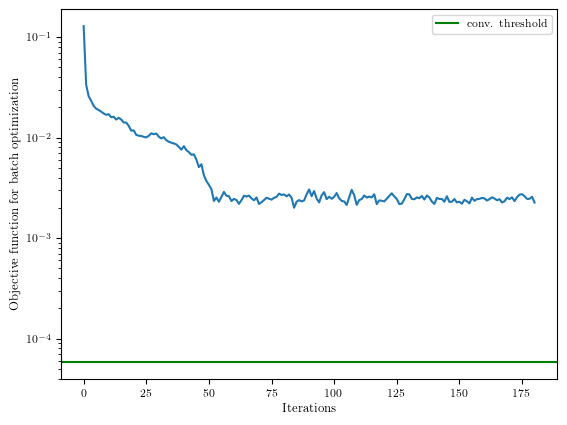

Run  3 failed, trying new initialization...
100%|███████████████████████████████████████████████████████████████████| 180/180 [04:49<00:00,  1.61s/it]


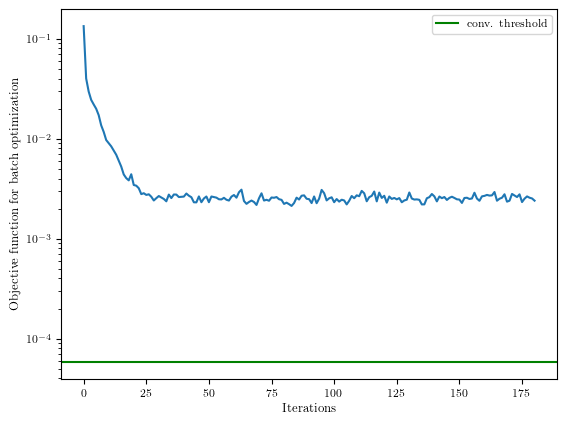

Run  4 failed, trying new initialization...
100%|███████████████████████████████████████████████████████████████████| 180/180 [04:44<00:00,  1.58s/it]


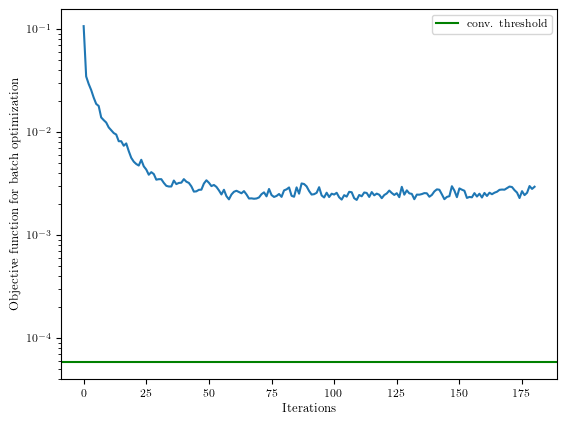

Run  5 failed, trying new initialization...
100%|███████████████████████████████████████████████████████████████████| 180/180 [04:40<00:00,  1.56s/it]


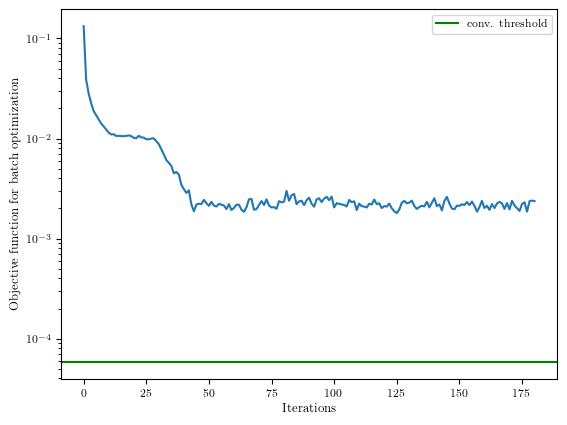

Run  6 failed, trying new initialization...
100%|███████████████████████████████████████████████████████████████████| 180/180 [05:00<00:00,  1.67s/it]


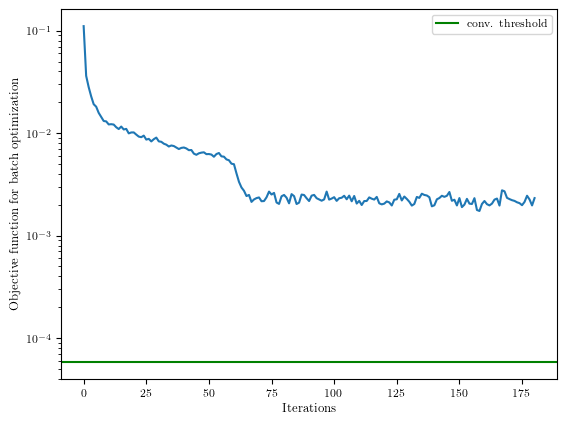

Run  7 failed, trying new initialization...
100%|███████████████████████████████████████████████████████████████████| 180/180 [04:38<00:00,  1.55s/it]


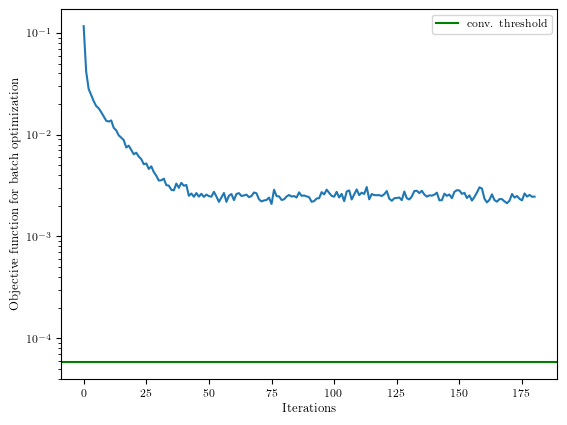

Run  8 failed, trying new initialization...
100%|███████████████████████████████████████████████████████████████████| 180/180 [04:39<00:00,  1.55s/it]


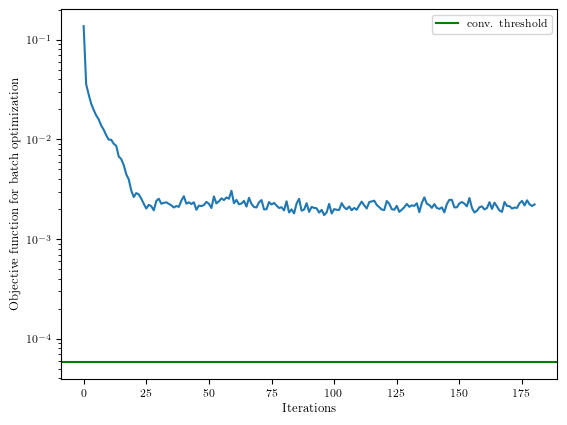

Maximum number of reinitializations reached without attaining success threshold, attempting optimization over full data set...
100%|█████████████████████████████████████████████████████████████████████| 30/30 [03:25<00:00,  6.85s/it]


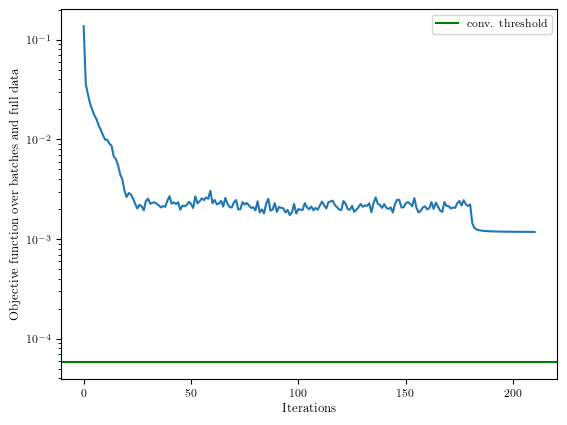

#################
	 Convergence criterion not satisfied, try increasing max_iter or using new initializations.
	 Final objective function value 0.0011804533331206631 with # of initializations: 10 
 	 Total runtime: 3059.723284959793
Starting optimization...
100%|█████████████████████████████████████████████████████████████████████| 30/30 [18:43<00:00, 37.44s/it]


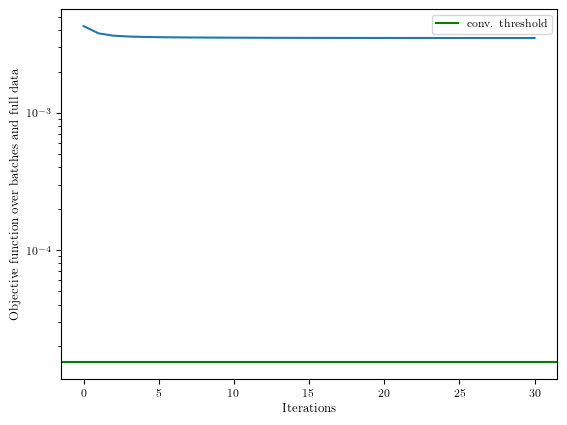

#################
	 Convergence criterion not satisfied, try increasing max_iter or using new initializations.
	 Final objective function value 0.003515226416462185 with # of initializations: 1 
 	 Total runtime: 1123.8689410686493


In [41]:
bsize = 120   # The batch size on which the optimization is started
results = []
rK = 2
for _ in range(1): # repeat multiple time or by using max_inits
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    K,X,E,rho,res_list = algorithm.run_mGST(y, J, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 10, max_iter = 180, final_iter = 30, threshold_multiplier = 4, 
                         target_rel_prec = 1e-4, testing = True)   
    K2,X2,E2,rho2,res_list2 = algorithm.run_mGST(y_all,J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 10, max_iter = 0, final_iter = 30, threshold_multiplier = 1, 
                         target_rel_prec = 1e-4, init = [K,E,rho], testing = True)   
    results.append([K2,X2,E2,rho2])

In [42]:
K3,X3,E3,rho3,res_list3 = algorithm.run_mGST(y_all,J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                     max_inits = 10, max_iter = 0, final_iter = 50, threshold_multiplier = 1, 
                     target_rel_prec = 1e-5, init = [K2,E2,rho2], testing = True) # check if more iterations help   

Starting optimization...
  0%|                                                                              | 0/50 [00:41<?, ?it/s]


SystemError: CPUDispatcher(<function ddM at 0x7fed508b3b80>) returned a result with an error set

In [123]:
K,X,E,rho = results[0][:]



weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 0}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)




df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)



,F_avg,Diamond distances,Min. Spectral distances
Id,"0,98747",None,"0,03092"
Rx(pi/2)[q0],"0,96205",None,"0,05405"
Ry(pi/2)[q0],"0,98710",None,"0,03559"
Rx(pi/2)[q1],"0,99228",None,"0,02310"
Ry(pi/2)[q1],"0,98200",None,"0,03446"
CZ[q0-q1],"0,69911",None,"0,66193"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.001537,0.038868,0.092499,0.092288,0.031061


(None, None)

In [54]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 0}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X2, E2, rho2, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)


df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, noisy_mdl, gate_labels)
display(s_g), display(s_o)


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99825","0,04667","0,04047"
Rx(pi/2)[q0],"0,20009","1,00000","0,04545"
Ry(pi/2)[q0],"0,99829","0,04873","0,03540"
Rx(pi/2)[q1],"0,20010","1,00000","0,02681"
Ry(pi/2)[q1],"0,99886","0,02460","0,01546"
CZ[q0-q1],"0,99845","0,04092","0,03221"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001628,0.047674,0.031704,0.018352


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99607","0,07733","0,00046"
Rx(pi/2)[q0],"0,20030","0,99986","0,00026"
Ry(pi/2)[q0],"0,99743","0,05770","0,00032"
Rx(pi/2)[q1],"0,20041","0,99986","0,00044"
Ry(pi/2)[q1],"0,99809","0,04204","0,00046"
CZ[q0-q1],"0,99550","0,08460","0,00040"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001628,0.001682,0.031704,0.043240


(None, None)

In [56]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1, 'rho0': 0}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X3, E3, rho3, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)


df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, noisy_mdl, gate_labels)
display(s_g), display(s_o)


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99824","0,04662","0,04041"
Rx(pi/2)[q0],"0,20020","1,00000","0,04548"
Ry(pi/2)[q0],"0,99826","0,04885","0,03539"
Rx(pi/2)[q1],"0,20009","1,00000","0,02685"
Ry(pi/2)[q1],"0,99889","0,02462","0,01546"
CZ[q0-q1],"0,99844","0,04118","0,03221"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001617,0.047674,0.031714,0.018311


,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99606","0,07735","0,00047"
Rx(pi/2)[q0],"0,20048","0,99984","0,00031"
Ry(pi/2)[q0],"0,99741","0,05768","0,00028"
Rx(pi/2)[q1],"0,20038","0,99986","0,00045"
Ry(pi/2)[q1],"0,99811","0,04202","0,00040"
CZ[q0-q1],"0,99550","0,08463","0,00035"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000001,0.001617,0.001682,0.031714,0.043217


(None, None)